In [128]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline, FeatureUnion

In [120]:
df2018 = pd.read_csv('data/nmhss2018.csv')
df2018.columns = map(str.lower, df2018.columns)

In [21]:
sli2018 = df2018.head(1000)
sli2018 = sli2018.filter(regex=("ip.*"))

basic_demog = ['ipsextotm','ipsextotf','ipagetot017','ipagetot1864','ipagetot65']
ip2018 = df2018[basic_demog]


In [5]:
colors=['red','green']

In [6]:
# scatter_matrix(ip2018,figsize=[20,20], marker='x',c=ip2018.fundsmha.apply(lambda x:colors[x]), diagonal='kde')
#

In [7]:
# Possible features to look at more:
# FUNDSMHA: Accepts state mental health agency funds as source of payment for mental health treatment services
# FUNDSTATEWELFARE: Accepts state welfare or child and family services agency funds as source of payment for treatment 
# FUNDSTATEJUV: Accepts state corrections/juvenile justice agency funds as source of payment for mental health treatment services (Q.A24)
# FUNDOTHSTATE: Accepts other state government funds as source of payment for mental health treatment services

In [22]:
val_map = {0: 0, 1: 5.5, 2: 15.5, 3: 25.5, 4: 35.5, 5: 45.5, 6: 63, 7: 88, 8: 175.5, 9: 375.5, 10: 750.5, 11: 1250.5,
           12: 1500, -1: None, -2: None}

In [38]:
patient_est = ip2018.replace(val_map)

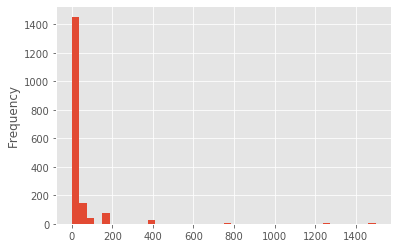

In [41]:
patient_est['ipsextotm'].plot.hist(bins=40)

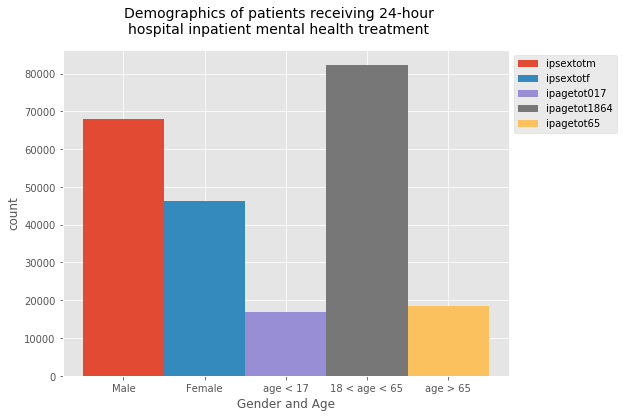

In [166]:
basic_demog = ['ipsextotm','ipsextotf','ipagetot017','ipagetot1864','ipagetot65']
ind = np.arange(len(basic_demog))
fig, ax = plt.subplots(figsize=(8, 6))

width = 0.2
for idx, demo in enumerate(basic_demog):
    ax.bar(idx*width, patient_est[patient_est[demo] > 0][demo].sum(), 
           width, label=demo)
    
plt.suptitle('Demographics of patients receiving 24-hour\nhospital inpatient mental health treatment', fontsize=14)
plt.ylabel('count')
plt.xlabel('Gender and Age')
plt.xticks(ind/5, ['Male', 'Female', 'age < 17', '18 < age < 65', 'age > 65'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')


In [124]:
# corr?

caseid             0.008992
mhintake           1.000000
mhdiageval         0.495927
mhreferral         0.398535
treatmt            0.174254
                     ...   
oplegaltotforen    0.176102
oplegalperforen    0.150979
cod_pct            0.017184
totadmis           0.131469
percentva          0.058162
Name: mhintake, Length: 283, dtype: float64

In [151]:
# predict funding based on data

standardizer = StandardScaler()

In [230]:
feature = 'publicagency'
facilities = df2018[df2018[feature] >= 0].select_dtypes(include=np.number) #only rows with 'known', numeric responses

X_facilities = facilities.drop([feature, 'caseid'], 1).clip(lower=0)
y_facilities = facilities[feature]


standardizer.fit(X_facilities)
X_facilities_standardized = standardizer.transform(X_facilities)

facilities_regression_standardized = LogisticRegression()

facilities_regression.fit(X_facilities_standardized, y_facilities)

/Users/jared/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jared/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [231]:
#Select 3 best
best_3_selector = SelectKBest(chi2, k=3)
best_3_selector.fit(X_facilities, y_facilities)
X_facilities_best = best_3_selector.transform(X_facilities)
X_facilities_best.shape

(2234, 3)

In [235]:
X_facilities.columns[best_3_selector.get_support()]

Index(['opagetot017', 'opraceperindian', 'percentva'], dtype='object')

In [236]:
facilities_predictions = facilities_regression.predict(X_facilities_standardized)
print(facilities_predictions[:10000])

[5 2 4 ... 6 3 1]


In [237]:
facilities_probabilities = facilities_regression.predict_proba(X_facilities_standardized)
print(facilities_probabilities[:10])

[[2.86912555e-01 1.65700341e-03 3.13711601e-03 3.23211883e-02
  6.69928921e-01 3.46818213e-03 2.57503348e-03]
 [3.45344900e-01 5.34596679e-01 1.02536028e-01 1.69460063e-03
  1.37833253e-02 7.41361058e-04 1.30310564e-03]
 [8.35255184e-03 4.16368195e-03 5.12490763e-03 9.77408951e-01
  1.16973794e-03 2.32756267e-03 1.45260732e-03]
 [1.48001785e-03 1.17857010e-03 3.70689406e-03 1.36178797e-03
  7.50198096e-03 9.80692987e-01 4.07776215e-03]
 [4.96276802e-02 3.36260320e-02 6.87670777e-02 1.49965887e-02
  7.86758269e-01 4.43311419e-02 1.89321016e-03]
 [2.48546954e-04 1.29728037e-04 8.47173616e-02 9.54404492e-02
  8.16239652e-01 1.42119490e-03 1.80306718e-03]
 [1.69785008e-03 4.03150491e-01 5.82481441e-01 3.71012533e-03
  7.61836806e-03 2.80093481e-04 1.06163066e-03]
 [3.31389870e-02 2.19248446e-02 4.65812167e-04 1.61476053e-03
  1.54904655e-03 9.37799694e-01 3.50685501e-03]
 [8.26736185e-01 1.21586493e-02 1.05998274e-01 3.69058252e-02
  9.32720852e-03 5.96776691e-03 2.90609090e-03]
 [8.712424

Text(0, 0.5, 'Probability of accepting funds')

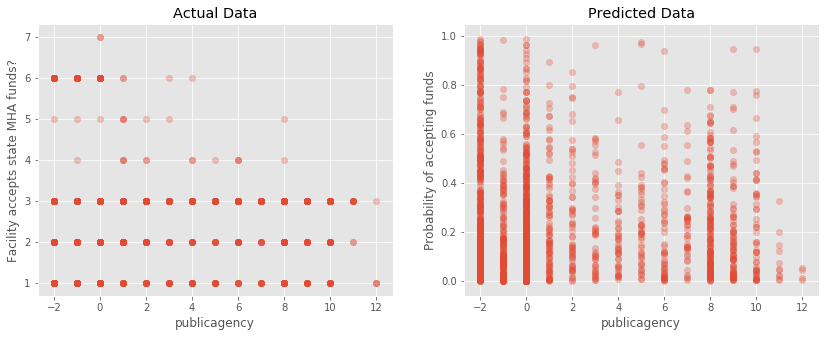

In [241]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].scatter(facilities.opagetot017, facilities[feature], s=40, alpha=0.3)
axs[0].set_title("Actual Data")
axs[0].set_xlabel(feature)
axs[0].set_ylabel("Facility accepts state MHA funds?")

axs[1].scatter(facilities.opagetot017, facilities_probabilities[:,1], s=40, alpha=0.3)
axs[1].set_title("Predicted Data")
axs[1].set_xlabel(feature)
axs[1].set_ylabel("Probability of accepting funds")



Text(0, 0.5, 'Probability of accepting funds')

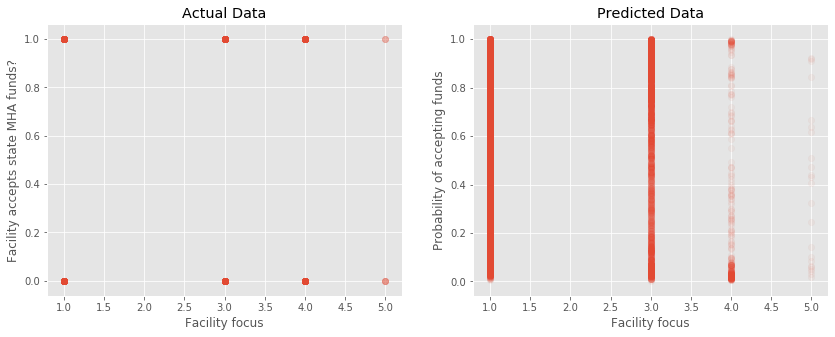

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].scatter(facilities.focus, facilities.fundsmha, s=40, alpha=0.05)
axs[0].set_title("Actual Data")
axs[0].set_xlabel("Facility focus")
axs[0].set_ylabel("Facility accepts state MHA funds?")

axs[1].scatter(facilities.focus, facilities_probabilities[:,1], s=40, alpha=0.05)
axs[1].set_title("Predicted Data")
axs[1].set_xlabel("Facility focus")
axs[1].set_ylabel("Probability of accepting funds")



True